# Chapter 5

`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`
____


### Would you rather lose an arm or a leg?

Statisticians can be a sour bunch. Instead of considering their winnings, they only measure how much they have lost. In fact, they consider their wins as *negative losses*. But what's interesting is *how they measure their losses.*

For example, consider the following example:

>   A meteorologist is predicting the probability of a possible hurricane striking his city. He estimates, with 95% confidence, that the probability of it *not* striking is between 99% - 100%. He is very happy with his precision and advises the city that a major evacuation is unnecessary. Unfortunately, the hurricane does strike and the city is flooded. 

This stylized example shows the flaw in using a pure accuracy metric to measure outcomes. Using a measure that emphasizes estimation accuracy, while an appealing and *objective* thing to do, misses the point of why you are even performing the statistical inference in the first place: results of inference. The author Nassim Taleb of *The Black Swan* and *Antifragility* stresses the importance of the *payoffs* of decisions, *not the accuracy*. Taleb distills this quite succinctly: "I would rather be vaguely right than very wrong."  

## Loss Functions

We introduce what statisticians and decision theorists call *loss functions*. A loss function is a function of the true parameter, and an estimate of that parameter

$$ L( \theta, \hat{\theta} ) = f( \theta, \hat{\theta} )$$

The important point of loss functions is that it measures how *bad* our current estimate is: the larger the loss, the worse the estimate is according to the loss function. A simple, and very common, example of a loss function is the *squared-error loss*:

$$ L( \theta, \hat{\theta} ) = ( \theta -  \hat{\theta} )^2$$

The squared-error loss function is used in estimators like linear regression, UMVUEs and many areas of machine learning. We can also consider an asymmetric squared-error loss function, something like:

$$ L( \theta, \hat{\theta} ) = \begin{cases} ( \theta -  \hat{\theta} )^2 & \hat{\theta} \lt \theta \\\\ c( \theta -  \hat{\theta} )^2 & \hat{\theta} \ge \theta, \;\; 0\lt c \lt 1 \end{cases}$$


which represents that estimating a value larger than the true estimate is preferable to estimating a value below. A situation where this might be useful is in estimating web traffic for the next month, where an over-estimated outlook is preferred so as to avoid an underallocation of server resources. 

A negative property about the squared-error loss is that it puts a disproportionate emphasis on large outliers. This is because the loss increases quadratically, and not linearly, as the estimate moves away. That is, the penalty of being three units away is much less than being five units away, but the penalty is not much greater than being one unit away, though in both cases the magnitude of difference is the same:

$$ \frac{1^2}{3^2} \lt \frac{3^2}{5^2}, \;\; \text{although} \;\; 3-1 = 5-3 $$

This loss function imposes that large errors are *very* bad. A more *robust* loss function that increases linearly with the difference is the *absolute-loss*

$$ L( \theta, \hat{\theta} ) = | \theta -  \hat{\theta} | $$

Other popular loss functions include:

-  $L( \theta, \hat{\theta} ) = \mathbb{1}_{ \hat{\theta} \neq \theta }$ is the zero-one loss often used in machine learning classification algorithms.
-  $L( \theta, \hat{\theta} ) = -\hat{\theta}\log( \theta ) - (1-\hat{ \theta})\log( 1 - \theta ), \; \; \hat{\theta} \in {0,1}, \; \theta \in [0,1]$, called the *log-loss*, also used in machine learning. 

Historically, loss functions have been motivated from 1) mathematical convenience, and 2) they are robust to application, i.e., they are objective measures of loss. The first reason has really held back the full breadth of loss functions. With computers being agnostic to mathematical convenience, we are free to design our own loss functions, which we take full advantage of later in this Chapter.

With respect to the second point, the above loss functions are indeed objective, in that they are most often a function of the difference between estimate and true parameter, independent of signage or payoff of choosing that estimate. This last point, its independence of payoff, causes quite pathological results though. Consider our hurricane example above: the statistician equivalently predicted that the probability of the hurricane striking was between 0% to 1%. But if he had ignored being precise and instead focused on outcomes (99% chance of no flood, 1% chance of flood), he might have advised differently. 

By shifting our focus from trying to be incredibly precise about parameter estimation to focusing on the outcomes of our parameter estimation, we can customize our estimates to be optimized for our application. This requires us to design new loss functions that reflect our goals and outcomes. Some examples of more interesting loss functions:


- $L( \theta, \hat{\theta} ) = \frac{ | \theta - \hat{\theta} | }{ \theta(1-\theta) }, \; \; \hat{\theta}, \theta \in [0,1]$ emphasizes an estimate closer to 0 or 1 since if the true value $\theta$ is near 0 or 1, the loss will be *very* large unless $\hat{\theta}$ is similarly close to 0 or 1. 
This loss function might be used by a political pundit who's job requires him or her to give confident "Yes/No" answers. This loss reflects that if the true parameter is close to 1 (for example, if a political outcome is very likely to occur), he or she would want to strongly agree as to not look like a skeptic. 

-  $L( \theta, \hat{\theta} ) =  1 - \exp \left( -(\theta -  \hat{\theta} )^2 \right)$ is bounded between 0 and 1 and reflects that the user is indifferent to sufficiently-far-away estimates. It is similar to the zero-one loss above, but not quite as penalizing to estimates that are close to the true parameter. 
-  Complicated non-linear loss functions can programmed: 

        def loss(true_value, estimate):
            if estimate*true_value > 0:
                return abs(estimate - true_value)
            else:
               return abs(estimate)*(estimate - true_value)**2
            


-  Another example is from the book *The Signal and The Noise*. Weather forecasters have an interesting loss function for their predictions.


>  People notice one type of mistake &mdash; the failure to predict rain &mdash; more than other, false alarms. If it rains when it isn't supposed to, they curse the weatherman for ruining their picnic, whereas an unexpectedly sunny day is taken as a serendipitous bonus.

>  [The Weather Channel's bias] is limited to slightly exaggerating the probability of rain when it is unlikely to occur &mdash; saying there is a 20 percent change when they know it is really a 5 or 10 percent chance &mdash; covering their butts in the case of an unexpected sprinkle.


As you can see, loss functions can be used for good and evil: with great power, comes great &mdash; well you know.


##  Loss functions in the real world

So far we have been under the unrealistic assumption that we know the true parameter. Of course if we knew the true parameter, bothering to guess an estimate is pointless. Hence a loss function is really only practical when the true parameter is unknown. 

In Bayesian inference, we have a mindset that the unknown parameters are really random variables with prior and posterior distributions. Concerning the posterior distribution, a value drawn from it is a *possible* realization of what the true parameter could be. Given that realization, we can compute a loss associated with an estimate. As we have a whole distribution of what the unknown parameter could be (the posterior), we should be more interested in computing the *expected loss* given an estimate. This expected loss is a better estimate of the true loss than comparing the given loss from only a single sample from the posterior.

First it will be useful to explain a *Bayesian point estimate*. The systems and machinery present in the modern world are not built to accept posterior distributions as input. It is also rude to hand someone over a distribution when all they asked for was an estimate.  In the course of an individual's day, when faced with uncertainty we still act by distilling our uncertainty down to a single action. Similarly, we need to distill our posterior distribution down to a single value (or vector in the multivariate case). If the value is chosen intelligently, we can avoid the flaw of frequentist methodologies that mask the uncertainty and provide a more informative result.The value chosen, if from a Bayesian posterior, is a Bayesian point estimate. 

Suppose $P(\theta | X)$ is the posterior distribution of $\theta$ after observing data $X$, then the following function is understandable as the *expected loss of choosing estimate $\hat{\theta}$ to estimate $\theta$*:

$$ l(\hat{\theta} ) = E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$

This is also known as the *risk* of estimate $\hat{\theta}$. The subscript $\theta$ under the expectation symbol is used to denote that $\theta$ is the unknown (random) variable in the expectation, something that at first can be difficult to consider.

We spent all of last chapter discussing how to approximate expected values. Given $N$ samples $\theta_i,\; i=1,...,N$ from the posterior distribution, and a loss function $L$, we can approximate the expected loss of using estimate $\hat{\theta}$ by the Law of Large Numbers:

$$\frac{1}{N} \sum_{i=1}^N \;L(\theta_i, \hat{\theta} ) \approx E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right]  = l(\hat{\theta} ) $$

Notice that measuring your loss via an *expected value* uses more information from the distribution than the MAP estimate which, if you recall, will only find the maximum value of the distribution and ignore the shape of the distribution. Ignoring information can over-expose yourself to tail risks, like the unlikely hurricane, and leaves your estimate ignorant of how ignorant you really are about the parameter.

Similarly, compare this with frequentist methods, that traditionally only aim to minimize the error, and do not consider the *loss associated with the result of that error*. Compound this with the fact that frequentist methods are almost guaranteed to never be absolutely accurate. Bayesian point estimates fix this by planning ahead: your estimate is going to be wrong, you might as well err on the right side of wrong.

##### Example: Optimizing for the *Showcase* on *The Price is Right*

Bless you if you are ever chosen as a contestant on the Price is Right, for here we will show you how to optimize your final price on the *Showcase*. For those who forget the rules:


1. Two contestants compete in *The Showcase*. 
2. Each contestant is shown a unique suite of prizes.
3. After the viewing, the contestants are asked to bid on the price for their unique suite of prizes.
4. If a bid price is over the actual price, the bid's owner is disqualified from winning.
5. If a bid price is under the true price by less than $250, the winner is awarded both prizes.

The difficulty in the game is balancing your uncertainty in the prices, keeping your bid low enough so as to not bid over, and trying to bid close to the price.

Suppose we have recorded the *Showcases* from previous *The Price is Right* episodes and have *prior* beliefs about what distribution the true price follows. For simplicity, suppose it follows a Normal:


$$\text{True Price} \sim \text{Normal}(\mu_p, \sigma_p )$$


In a later chapter, we will actually use *real Price is Right Showcase data* to form the historical prior, but this requires some advanced PyMC3 use so we will not use it here. For now, we will assume $\mu_p = 35 000$ and $\sigma_p = 7500$.

We need a model of how we should be playing the *Showcase*. For each prize in the prize suite, we have an idea of what it might cost, but this guess could differ significantly from the true price. (Couple this with increased pressure being onstage and you can see why some bids are so wildly off). Let's suppose your beliefs about the prices of prizes also follow Normal distributions:

$$ \text{Prize}_i \sim \text{Normal}(\mu_i, \sigma_i ),\;\; i=1,2$$

This is really why Bayesian analysis is great: we can specify what we think a fair price is through the $\mu_i$ parameter, and express uncertainty of our guess in the $\sigma_i$ parameter. 

We'll assume two prizes per suite for brevity, but this can be extended to any number. 
The true price of the prize suite is then given by $\text{Prize}_1 + \text{Prize}_2 + \epsilon$, 
where $\epsilon$ is some error term.

We are interested in the updated $\text{True Price}$ given we have observed both prizes and have belief distributions about them. We can perform this using PyMC3. 

Lets make some values concrete. Suppose there are two prizes in the observed prize suite: 

1. A trip to wonderful Toronto, Canada! 
2. A lovely new snowblower!

We have some guesses about the true prices of these objects, but we are also pretty uncertain about them. I can express this uncertainty through the parameters of the Normals:


\begin{align}
& \text{snowblower} \sim \text{Normal}(3 000, 500 )\\\\
& \text{Toronto} \sim \text{Normal}(12 000, 3000 )\\\\
\end{align}

For example, I believe that the true price of the trip to Toronto is 12 000 dollars, and that there is a 68.2% chance the price falls 1 standard deviation away from this, i.e. my confidence is that there is a 68.2% chance the trip is in [9 000, 15 000].

We can create some PyMC3 code to perform inference on the true price of the suite.

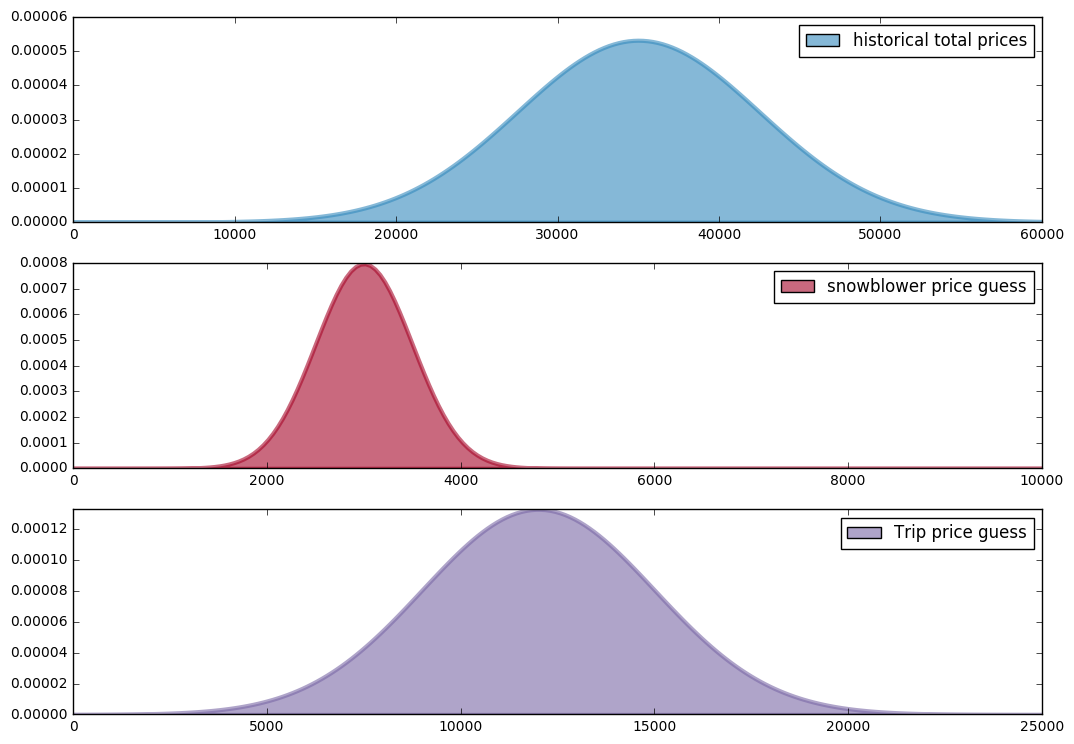

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x , 0, norm_pdf(x, 35000, 7500), 
                color = "#348ABD", lw = 3, alpha = 0.6,
                label = "historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x , 0, norm_pdf(x, 3000, 500), 
                 color = "#A60628", lw = 3, alpha = 0.6,
                 label="snowblower price guess")

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x , 0, norm_pdf(x, 12000, 3000), 
                 color = "#7A68A6", lw = 3, alpha = 0.6,
                 label = "Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

In [14]:
import pymc3 as pm

data_mu = [3e3, 12e3]

data_std =  [5e2, 3e3] 

mu_prior = 35e3
std_prior =  75e2
with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)
    

    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]

price_trace = burned_trace["true_price"]
prize_1_trace = burned_trace['first_prize']
prize_2_trace = burned_trace['second_prize']

100%|██████████| 50000/50000 [00:08<00:00, 5606.98it/s]


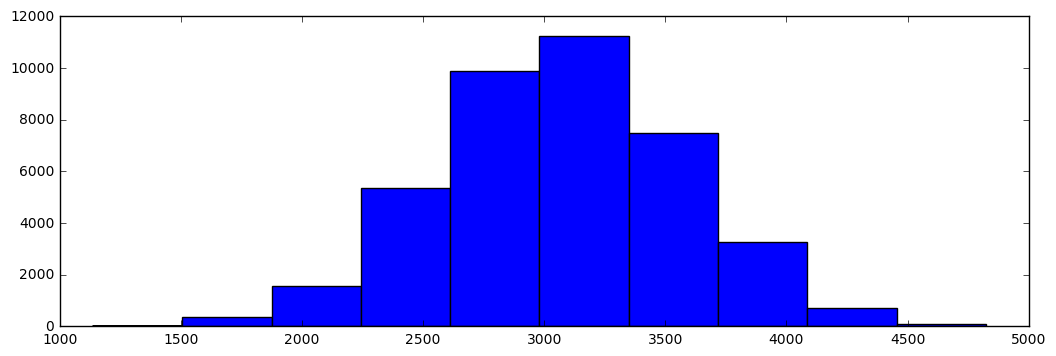

In [16]:
plt.hist(prize_1_trace);

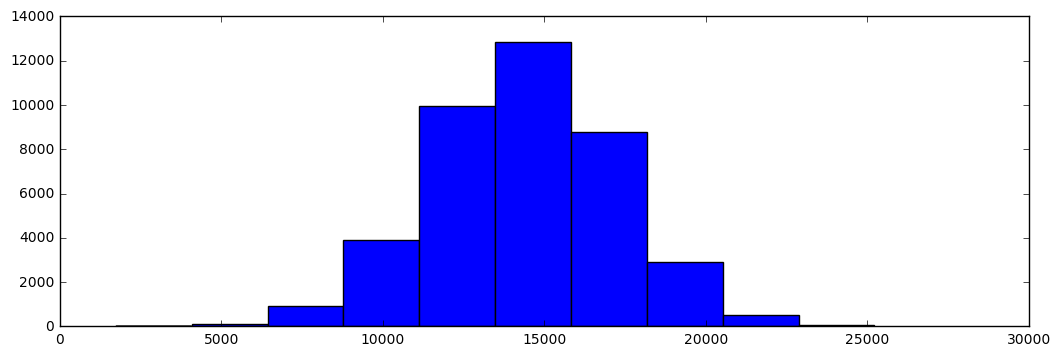

In [18]:
plt.hist(prize_2_trace);


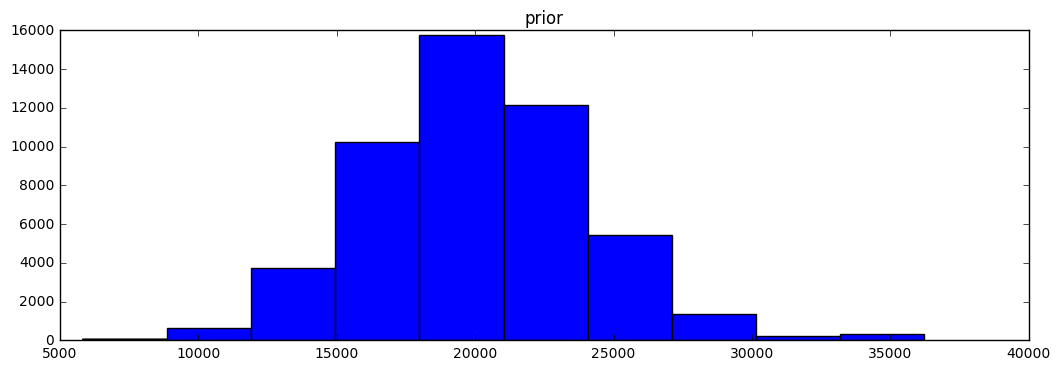

In [13]:
plt.hist(trace.get_values('true_price'))
plt.title('prior')

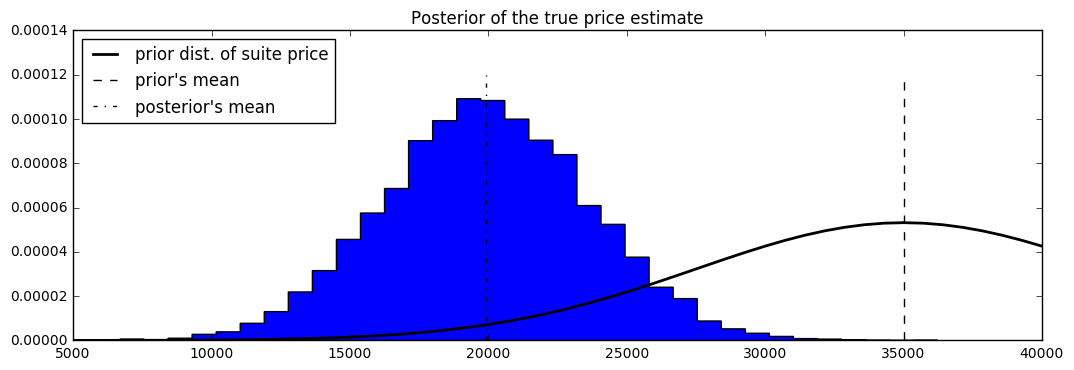

In [3]:
figsize(12.5, 4)

import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, 
         label = "prior dist. of suite price")

_hist = plt.hist(price_trace, bins = 35, normed= True, histtype= "stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label = "prior's mean",
           linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), \
           label = "posterior's mean", linestyles="-.")
plt.legend(loc = "upper left");

Notice that because of our two observed prizes and subsequent guesses (including uncertainty about those guesses), we shifted our mean price estimate down about \$15,000 dollars from the previous mean price.

A frequentist, seeing the two prizes and having the same beliefs about their prices, would bid $\mu_1 + \mu_2 = 35000$, regardless of any uncertainty. Meanwhile, the *naive Bayesian* would simply pick the mean of the posterior distribution. But we have more information about our eventual outcomes; we should incorporate this into our bid. We will use the loss function above to find the *best* bid (*best* according to our loss).

What might a contestant's loss function look like? I would think it would look something like:

    def showcase_loss(guess, true_price, risk = 80000):
        if true_price < guess:
            return risk
        elif abs(true_price - guess) <= 250:
            return -2*np.abs(true_price)
        else:
            return np.abs(true_price - guess - 250)

where `risk` is a parameter that defines of how bad it is if your guess is over the true price. A lower `risk` means that you are more comfortable with the idea of going over. If we do bid under and the difference is less than $250, we receive both prizes (modeled here as receiving twice the original prize). Otherwise, when we bid under the `true_price` we want to be as close as possible, hence the `else` loss is a increasing function of the distance between the guess and true price.

For every possible bid, we calculate the *expected loss* associated with that bid. We vary the `risk` parameter to see how it affects our loss:

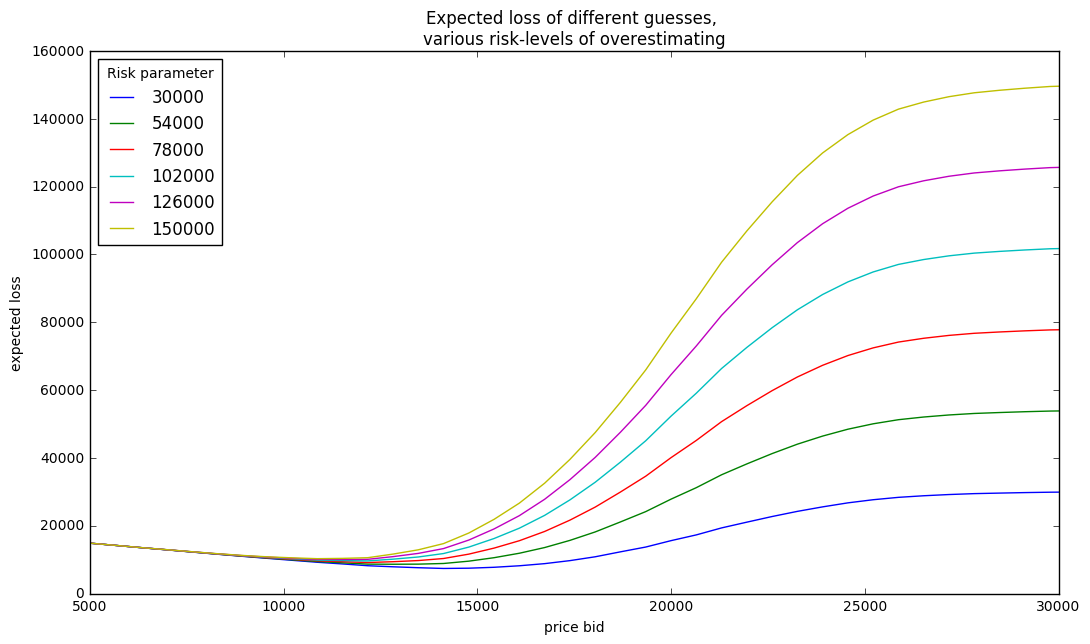

In [19]:
figsize(12.5, 7)
#numpy friendly showdown_loss


def showdown_loss(guess, true_price, risk = 80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70) 
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()
        
for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)
    
plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);

### Minimizing our losses

It would be wise to choose the estimate that minimizes our expected loss. This corresponds to the minimum point on each of the curves above. More formally, we would like to minimize our expected loss by finding the solution to

$$ \text{arg} \min_{\hat{\theta}} \;\;E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$

The minimum of the expected loss is called the *Bayes action*. We can solve for the Bayes action using Scipy's optimization routines. The function in `fmin` in `scipy.optimize` module uses an intelligent search to find a minimum (not necessarily a *global* minimum) of any uni- or multivariate function. For most purposes, `fmin` will provide you with a good answer. 

We'll compute the minimum loss for the *Showcase* example above:


minimum at risk 30000: 14610.31
minimum at risk 54000: 12630.20
minimum at risk 78000: 12094.21
minimum at risk 102000: 11877.93
minimum at risk 126000: 11366.10
minimum at risk 150000: 11354.44


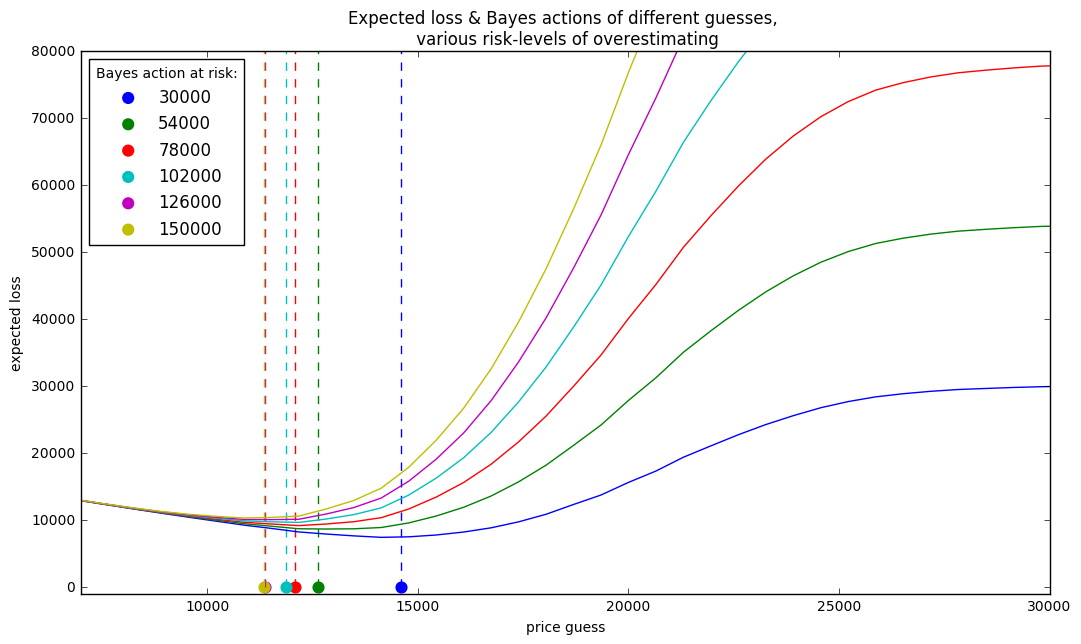

In [20]:
import scipy.optimize as sop

ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))
                                    
plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints = 1, title = "Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

As intuition suggests, as we decrease the risk threshold (care about overbidding less), we increase our bid, willing to edge closer to the true price. It is interesting how far away our optimized loss is from the posterior mean, which was about 20 000. 

Suffice to say, in higher dimensions being able to eyeball the minimum expected loss is impossible. Hence why we require use of Scipy's `fmin` function.



______

### Shortcuts

For some loss functions, the Bayes action is known in closed form. We list some of them below:

-  If using the mean-squared loss, the Bayes action is the mean of the posterior distribution, i.e. the value $$ E_{\theta}\left[ \theta \right] $$ minimizes $E_{\theta}\left[ \; (\theta - \hat{\theta})^2 \; \right]$. Computationally this requires us to calculate the average of the posterior samples [See chapter 4 on The Law of Large Numbers]

-  Whereas the *median* of the posterior distribution minimizes the expected absolute-loss. The sample median of the posterior samples is an appropriate and very accurate approximation to the true median.

-  In fact, it is possible to show that the MAP estimate is the solution to using a loss function that shrinks to the zero-one loss.


Maybe it is clear now why the first-introduced loss functions are used most often in the mathematics of Bayesian inference: no complicated optimizations are necessary. Luckily, we have machines to do the complications for us. 

##  Machine Learning via Bayesian Methods

Whereas frequentist methods strive to achieve the best precision about all possible parameters, machine learning cares to achieve the best *prediction* among all possible parameters. Of course, one way to achieve accurate predictions is to aim for accurate predictions, but often your prediction measure and what frequentist methods are optimizing for are very different. 

For example, least-squares linear regression is the most simple active machine learning algorithm. I say active as it engages in some learning, whereas predicting the sample mean is technically *simpler*, but is learning very little if anything. The loss that determines the coefficients of the regressors is a squared-error loss. On the other hand, if your prediction loss function (or score function, which is the negative loss) is not a squared-error, like AUC, ROC, precision, etc., your least-squares line will not be optimal for the prediction loss function. This can lead to prediction results that are suboptimal. 

Finding Bayes actions is equivalent to finding parameters that optimize *not parameter accuracy* but an arbitrary performance measure, however we wish to define performance (loss functions, AUC, ROC, precision/recall etc.).

The next two examples demonstrate these ideas. The first example is a linear model where we can choose to predict using the least-squares loss or a novel, outcome-sensitive loss. 

The second example is adapted from a Kaggle data science project. The loss function associated with our predictions is incredibly complicated. 




##### Example: Financial prediction


Suppose the future return of a stock price is very small, say 0.01 (or 1%). We have a model that predicts the stock's future price, and our profit and loss is directly tied to us acting on the prediction.  How should we measure the loss associated with the model's predictions, and subsequent future predictions? A squared-error loss is agnostic to the signage and would penalize a prediction of -0.01 equally as bad a prediction of 0.03:

$$ (0.01 - (-0.01))^2 = (0.01 - 0.03)^2 = 0.004$$

If you had made a bet based on your model's prediction, you would have earned money with a prediction of 0.03, and lost money with a prediction of -0.01, yet our loss did not capture this. We need a better loss that takes into account the *sign* of the prediction and true value. We design a new loss that is better for financial applications below:

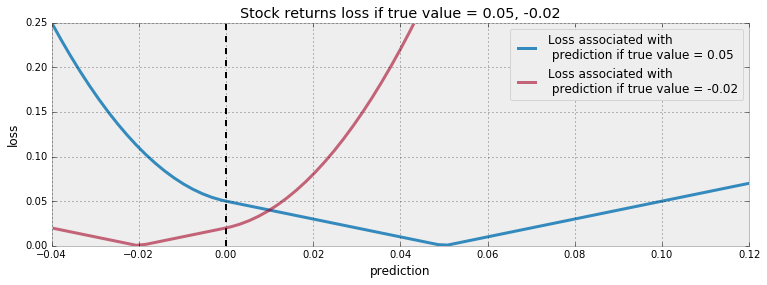

In [7]:
figsize(12.5, 4)


def stock_loss(true_return, yhat, alpha = 100.):
    if true_return * yhat < 0:
        #opposite signs, not good
        return alpha*yhat**2 - np.sign(true_return)*yhat \
                        + abs(true_return) 
    else:
        return abs(true_return - yhat)
    
    
true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], \
        label = "Loss associated with\n prediction if true value = 0.05", lw =3) 
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha = 0.6, \
        label = "Loss associated with\n prediction if true value = -0.02", lw =3) 
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");

Note the change in the shape of the loss as the prediction crosses zero. This loss reflects that the user really does not want to guess the wrong sign, especially be wrong *and* a large magnitude. 

Why would the user care about the magnitude? Why is the loss not 0 for predicting the correct sign? Surely, if the return is 0.01 and we bet millions we will still be (very) happy.

Financial institutions treat downside risk, as in predicting a lot on the wrong side, and upside risk, as in predicting a lot on the right side, similarly. Both are seen as risky behaviour and discouraged. Hence why we have an increasing loss as we move further away from the true price. (With less extreme loss in the direction of the correct sign.)

We will perform a regression on a trading signal that we believe predicts future returns well. Our dataset is artificial, as most financial data is not even close to linear. Below, we plot the data along with the least-squares line.

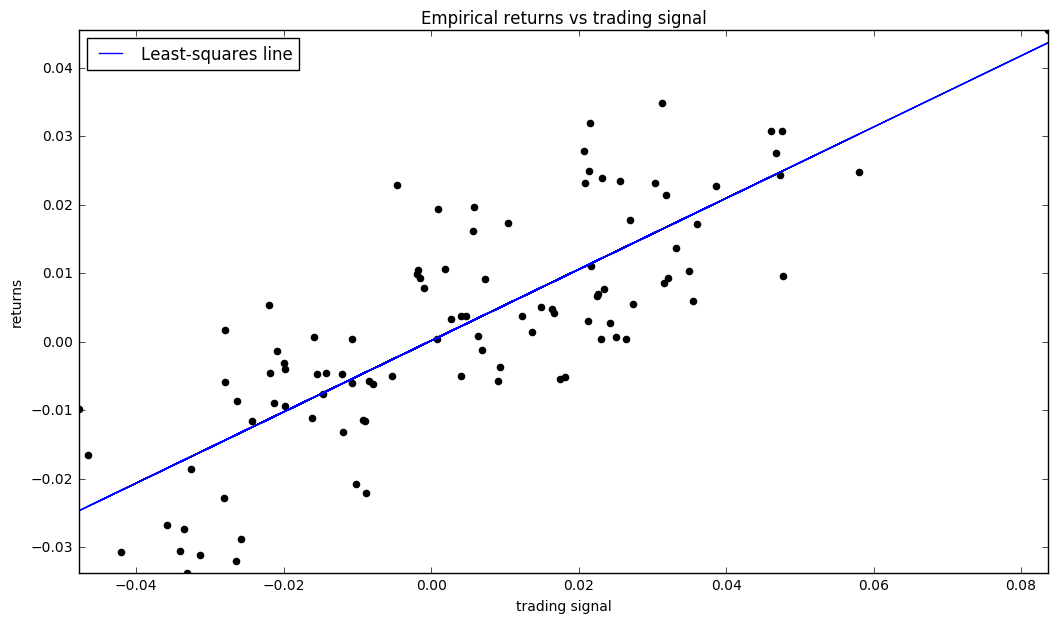

In [22]:
## Code to create artificial data
N = 100
X = 0.025*np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N) 

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label = "Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

We perform a simple Bayesian linear regression on this dataset. We look for a model like:

$$ R = \alpha + \beta x + \epsilon$$

where $\alpha, \beta$ are our unknown parameters and $\epsilon \sim \text{Normal}(0, \sigma)$. The most common priors on $\beta$ and $\alpha$ are Normal priors. We will also assign a prior on $\sigma$, so that $\sigma$ is uniform over 0 to 100.

In [25]:
import pymc3 as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    
    mean = pm.Deterministic("mean", alpha + beta*X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]  

100%|██████████| 100000/100000 [00:21<00:00, 4601.40it/s]


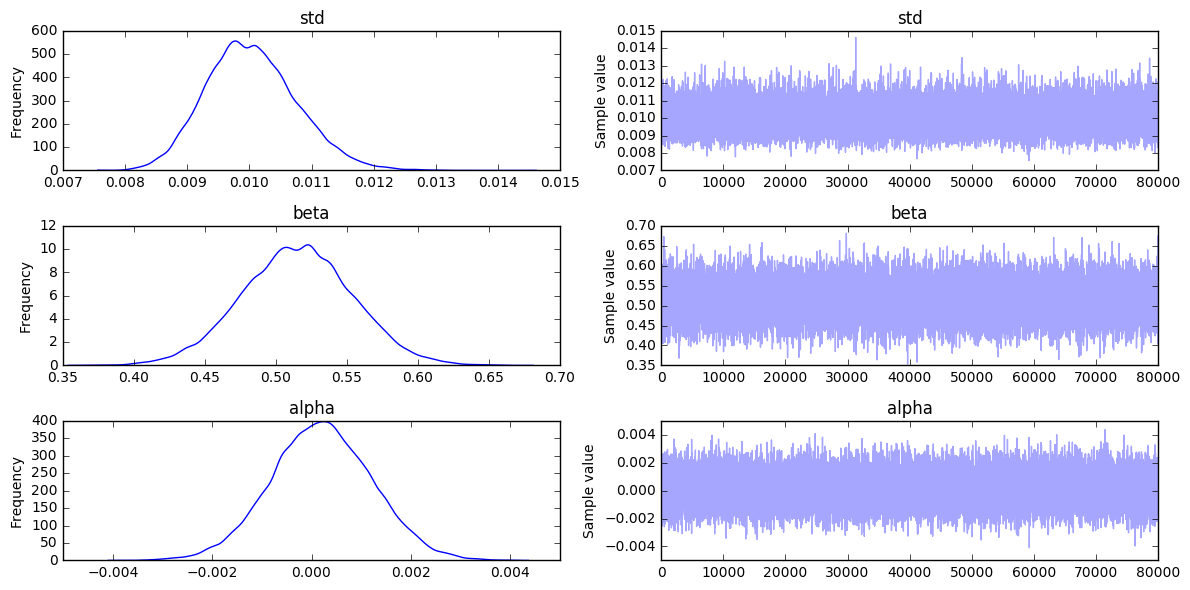

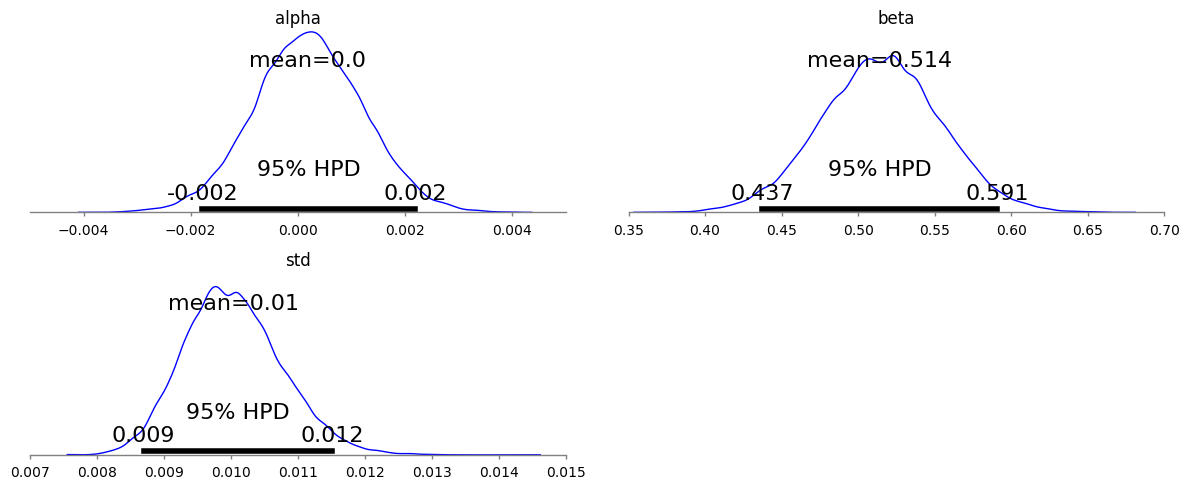

In [26]:
pm.plots.traceplot(trace=burned_trace, varnames=["std", "beta", "alpha"])
pm.plot_posterior(trace=burned_trace, varnames=["std", "beta", "alpha"], kde_plot=True);

It appears the MCMC has converged so we may continue.

For a specific trading signal, call it $x$, the distribution of possible returns has the form:

$$R_i(x) =  \alpha_i + \beta_ix + \epsilon $$

where $\epsilon \sim \text{Normal}(0, \sigma_i)$ and $i$ indexes our posterior samples. We wish to find the solution to 

$$ \arg \min_{r} \;\;E_{R(x)}\left[ \; L(R(x), r) \; \right] $$

according to the loss given above. This $r$ is our Bayes action for trading signal $x$. Below we plot the Bayes action over different trading signals. What do you notice?


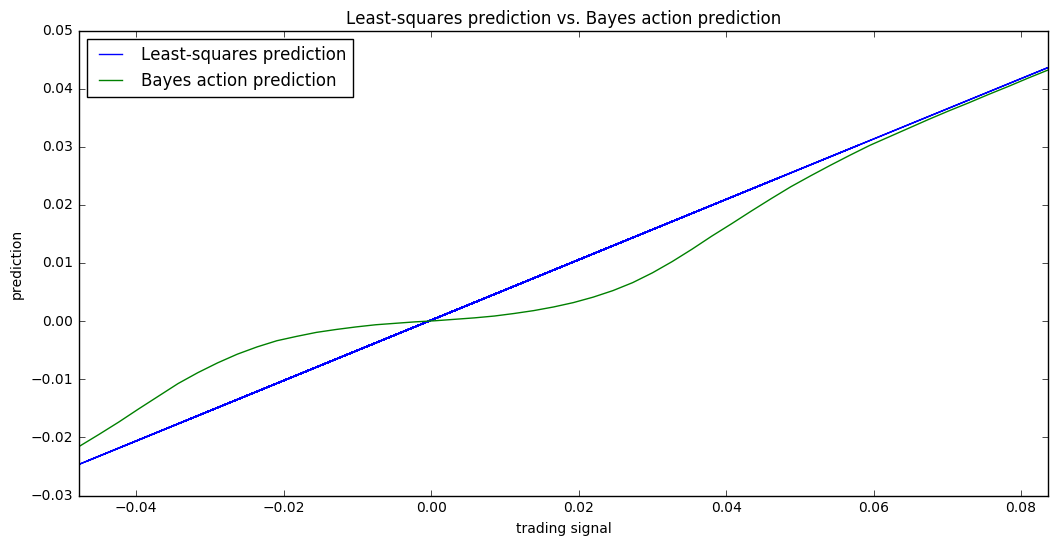

In [27]:
figsize(12.5, 6)
from scipy.optimize import fmin


def stock_loss(price, pred, coef = 500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise


opt_predictions = np.zeros(50)
trading_signals =  np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
        _possible_outcomes = possible_outcomes(_signal)
        tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
        opt_predictions[i] = fmin(tomin, 0, disp = False)
        
        
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label ="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
plt.legend(loc="upper left");

What is interesting about the above graph is that when the signal is near 0, and many of the possible  returns outcomes are possibly both positive and negative, our best (with respect to our loss) prediction is to predict close to 0, hence *take on no position*. Only when we are very confident do we enter into a position. I call this style of model a *sparse prediction*, where we feel uncomfortable with our uncertainty so choose not to act. (Compare with the least-squares prediction which will rarely, if ever, predict zero). 

A good sanity check that our model is still reasonable: as the signal becomes more and more extreme, and we feel more and more confident about the positive/negativeness of returns, our position converges with that of the least-squares line. 

The sparse-prediction model is not trying to *fit* the data the best (according to a *squared-error loss* definition of *fit*). That honor would go to the least-squares model. The sparse-prediction model is trying to find the best prediction *with respect to our `stock_loss`-defined loss*. We can turn this reasoning around: the least-squares model is not trying to *predict* the best (according to a *`stock-loss`* definition of *predict*). That honor would go the *sparse prediction* model. The least-squares model is trying to find the best fit of the data *with respect to the squared-error loss*.


##### Example: Kaggle contest on *Observing Dark World*


A personal motivation for learning Bayesian methods was trying to piece together the winning solution to Kaggle's [*Observing Dark Worlds*](http://www.kaggle.com/c/DarkWorlds) contest. From the contest's website:



>There is more to the Universe than meets the eye. Out in the cosmos exists a form of matter that outnumbers the stuff we can see by almost 7 to 1, and we don’t know what it is. What we do know is that it does not emit or absorb light, so we call it Dark Matter. Such a vast amount of aggregated matter does not go unnoticed. In fact we observe that this stuff aggregates and forms massive structures called Dark Matter Halos. Although dark, it warps and bends spacetime such that any light from a background galaxy which passes close to the Dark Matter will have its path altered and changed. This bending causes the galaxy to appear as an ellipse in the sky.

<img src="http://timsalimans.com/wp-content/uploads/2012/12/dm.jpg" width = 730>


The contest required predictions about where dark matter was likely to be. The winner, [Tim Salimans](http://timsalimans.com/), used Bayesian inference to find the best locations for the halos (interestingly, the second-place winner also used Bayesian inference). With Tim's permission, we provided his solution [1] here:

1. Construct a prior distribution for the halo positions $p(x)$, i.e. formulate our expectations about the halo positions before looking at the data.
2. Construct a probabilistic model for the data (observed ellipticities of the galaxies) given the positions of the dark matter halos: $p(e | x)$.
3. Use Bayes’ rule to get the posterior distribution of the halo positions, i.e. use to the data to guess where the dark matter halos might be.
4. Minimize the expected loss with respect to the posterior distribution over the predictions for the halo positions: $\hat{x} = \arg \min_{\text{prediction} } E_{p(x|e)}[ L( \text{prediction}, x) ]$ , i.e. tune our predictions to be as good as possible for the given error metric.



The loss function in this problem is very complicated. For the very determined, the loss function is contained in the file DarkWorldsMetric.py in the parent folder. Though I suggest not reading it all, suffice to say the loss function is about 160 lines of code &mdash; not something that can be written down in a single mathematical line. The loss function attempts to measure the accuracy of prediction, in a Euclidean distance sense, such that no shift-bias is present. More details can be found on the metric's [main page](http://www.kaggle.com/c/DarkWorlds/details/evaluation). 

We will attempt to implement Tim's winning solution using PyMC3 and our knowledge of loss functions.

### The Data

The dataset is actually 300 separate files, each representing a sky. In each file, or sky, are between 300 and 720 galaxies. Each galaxy has an $x$ and $y$ position associated with it, ranging from 0 to 4200, and measures of ellipticity: $e_1$ and $e_2$. Information about what these measures mean can be found [here](https://www.kaggle.com/c/DarkWorlds/details/an-introduction-to-ellipticity), but for our purposes it does not matter besides for visualization purposes. Thus a typical sky might look like the following:

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[  1.62690000e+02   1.60006000e+03   1.14664000e-01  -1.90326000e-01]
 [  2.27228000e+03   5.40040000e+02   6.23555000e-01   2.14979000e-01]
 [  3.55364000e+03   2.69771000e+03   2.83527000e-01  -3.01870000e-01]]


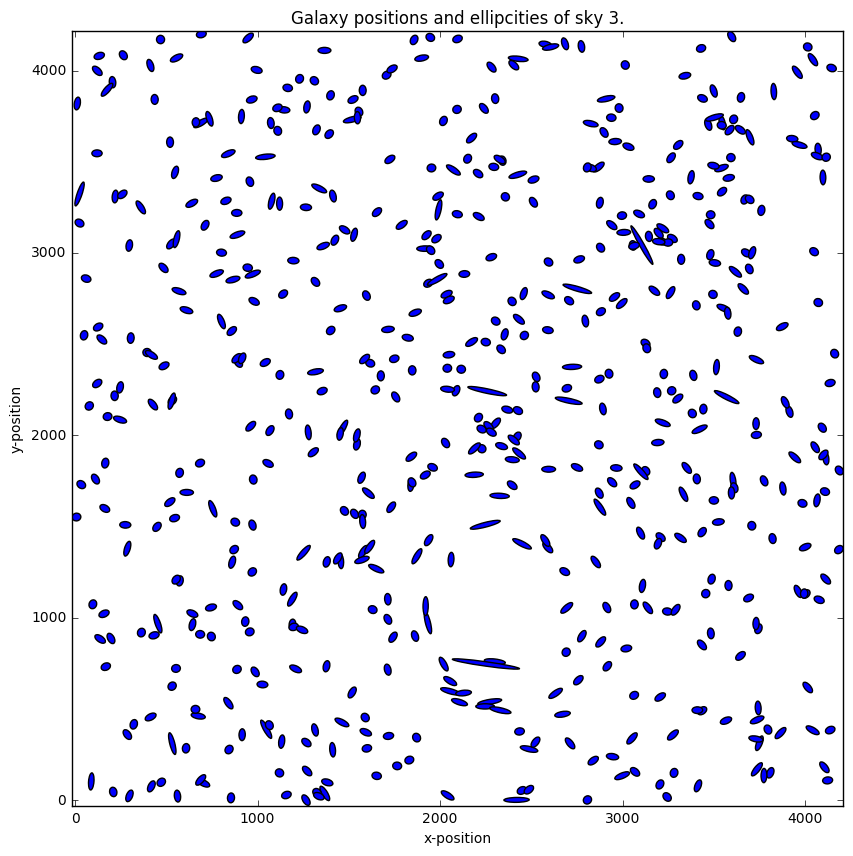

In [28]:
from draw_sky2 import draw_sky

n_sky = 3 #choose a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");

### Priors

Each sky has one, two or three dark matter halos in it. Tim's solution details that his prior distribution of halo positions was uniform, i.e.

\begin{align}
& x_i \sim \text{Uniform}( 0, 4200)\\\\
& y_i \sim \text{Uniform}( 0, 4200), \;\; i=1,2,3\\\\
\end{align}

Tim and other competitors noted that most skies had one large halo and other halos, if present, were much smaller. Larger halos, having more mass, will influence the surrounding galaxies more. He decided that the large halos would have a mass distributed as a *log*-uniform random variable between 40 and 180 i.e.

$$  m_{\text{large} } = \log \text{Uniform}( 40, 180 ) $$

and in PyMC3, 

    exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
    mass_large = pm.Deterministic("mass_large", np.log(exp_max_large))

(This is what we mean when we say *log*-uniform.) For smaller galaxies, Tim set the mass to be the logarithm of 20. Why did Tim not create a prior for the smaller mass, nor treat it as a unknown? I believe this decision was made to speed up convergence of the algorithm. This is not too restrictive, as by construction the smaller halos have less influence on the galaxies.

Tim logically assumed that the ellipticity of each galaxy is dependent on the position of the halos, the distance between the galaxy and halo, and the mass of the halos. Thus the vector of ellipticity of each galaxy, $\mathbf{e}_i$, are *children* variables of the vector of halo positions $(\mathbf{x},\mathbf{y})$, distance (which we will formalize), and halo masses.

Tim conceived a relationship to connect positions and ellipticity by reading literature and forum posts. He supposed the following was a reasonable relationship:

$$ e_i | ( \mathbf{x}, \mathbf{y} ) \sim \text{Normal}( \sum_{j = \text{halo positions} }d_{i,j} m_j f( r_{i,j} ), \sigma^2 ) $$

where $d_{i,j}$ is the *tangential direction* (the direction in which halo $j$ bends the light of galaxy $i$), $m_j$ is the mass of halo $j$, $f(r_{i,j})$ is a *decreasing function* of the Euclidean distance between halo $j$ and galaxy $i$. 

Tim's function $f$ was defined:

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 240 ) } $$

for large halos, and for small halos

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 70 ) } $$

This fully bridges our observations and unknown. This model is incredibly simple, and Tim mentions this simplicity was purposefully designed: it prevents the model from overfitting.  


### Training & PyMC3 implementation

For each sky, we run our Bayesian model to find the posteriors for the halo positions &mdash; we ignore the (known) halo position. This is slightly different than perhaps traditional approaches to Kaggle competitions, where this model uses no data from other skies nor the known halo location. That does not mean other data are not necessary &mdash; in fact, the model was created by comparing different skies. 


In [29]:
import pymc3 as pm
import theano.tensor as T

def euclidean_distance(x, y):
    return np.sqrt(((x - y)**2)).sum(axis=1)

def f_distance(gxy_pos, halo_pos, c):
    # foo_position should be a 2-d numpy array
    # T.maximum() provides our element-wise maximum as in NumPy, but instead for theano tensors
    return T.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    # foo_position should be a 2-d numpy array
    delta = glxy_position - halo_position
    t = (2*T.arctan(delta[:,1]/delta[:,0]))
    return T.stack([-T.cos(t), -T.sin(t)], axis=1)


with pm.Model() as model:
    #set the size of the halo's mass
    mass_large = pm.Uniform("mass_large", 40, 180)
    
    #set the initial prior position of the halos, it's a 2-d Uniform dist.
    halo_position = pm.Uniform("halo_position", 0, 4200, shape=(1,2))
    
    mean = pm.Deterministic("mean", mass_large /\
            f_distance(T.as_tensor(data[:,:2]), halo_position, 240)*\
            tangential_distance(T.as_tensor(data[:,:2]), halo_position))
    
    ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])

In [30]:
with model:
    mu, sds, elbo = pm.variational.advi(n=50000)
    step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
    trace = pm.sample(5000, step=step, start=mu)

KeyboardInterrupt: 

We use ADVI here to find a good starting point and scaling for our NUTS sampler. NUTS is a "smarter" MCMC sampling method than Metropolis, so as a result we need fewer total samples for our chains to converge. ADVI follows a completely different methodology to fit a model that we will not get into here. We may cover ADVI, as well as NUTS, in-depth in a later chapter.

Below we plot a "heatmap" of the posterior distribution. (Which is just a scatter plot of the posterior, but we can visualize it as a heatmap.)

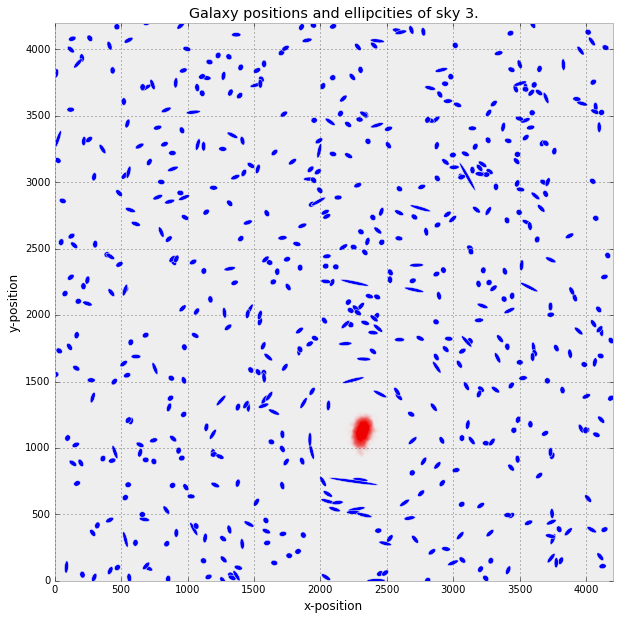

In [15]:
t = trace["halo_position"].reshape(5000,2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

The most probable position reveals itself like a lethal wound.

Associated with each sky is another data point, located in `./data/Training_halos.csv` that holds the locations of up to three dark matter halos contained in the sky. For example, the night sky we trained on has halo locations:

In [16]:
halo_data = np.genfromtxt("data/Training_halos.csv", 
                          delimiter = ",",
                          usecols = [1, 2,3, 4,5,6,7,8,9],
                          skip_header = 1)
print(halo_data[n_sky])

[  1.00000000e+00   1.40861000e+03   1.68586000e+03   1.40861000e+03
   1.68586000e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


The third and fourth column represent the true $x$ and $y$ position of the halo. It appears that the Bayesian method has located the halo within a tight vicinity. 

True halo location: 1408.61 1685.86


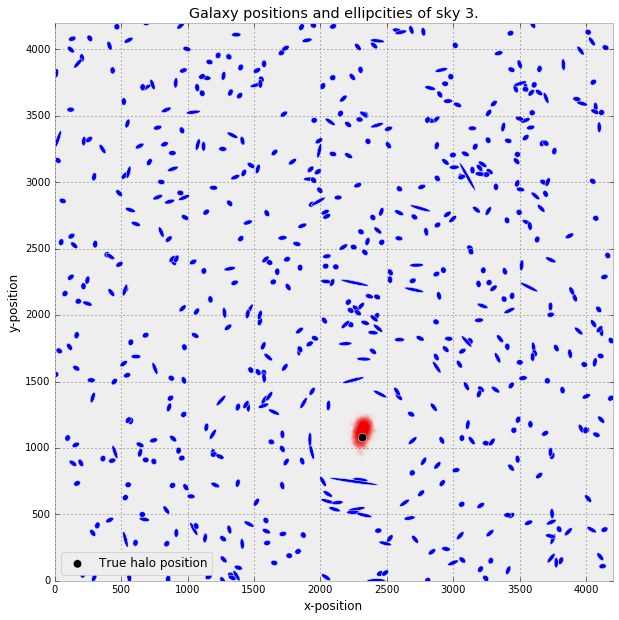

In [17]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4], 
            label = "True halo position",
            c = "k", s = 70)
plt.legend(scatterpoints = 1, loc = "lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

Perfect. Our next step is to use the loss function to optimize our location. A naive strategy would be to simply choose the mean:

In [18]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print(mean_posterior)

[[ 2312.96009501  1127.87170923]]


In [19]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky-1]

nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, random_guess)

Using the mean:
Your average distance in pixels you are away from the true halo is 46.0082084242
Your average angular vector is 1.0
Your score for the training data is 1.04600820842
Using a random location: [[ 288 3167]]
Your average distance in pixels you are away from the true halo is 2908.49191694
Your average angular vector is 1.0
Your score for the training data is 3.90849191694


3.9084919169390866

This is a good guess, it is not very far from the true location, but it ignores the loss function that was provided to us. We also need to extend our code to allow for up to two additional, *smaller* halos: Let's create a function for automatizing our PyMC3. 

In [20]:
def halo_posteriors(n_halos_in_sky, galaxy_data,samples = 5e5, burn_in = 500):
    #set the size of the halo's mass
    with pm.Model() as model:
        mass_large = pm.Uniform("mass_large", 40, 180)
        
        mass_small_1 = 20
        mass_small_2 = 20
    
        masses = np.array([mass_large,mass_small_1, mass_small_2], dtype=object)
    
        #set the initial prior positions of the halos, it's a 2-d Uniform dist.
        halo_positions = pm.Uniform("halo_positions", 0, 4200, shape=(n_halos_in_sky,2)) #notice this size
    
        fdist_constants = np.array([240, 70, 70])
        
        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += masses[i]/f_distance(data[:,:2], halo_positions[i, :], fdist_constants[i])*\
                tangential_distance(data[:,:2], halo_positions[i, :])
        
        mean = pm.Deterministic("mean", _sum)
               
        ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])
    
        mu, sds, elbo = pm.variational.advi(n=50000)
        step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
        trace = pm.sample(samples, step=step, start=mu)
        
    burned_trace = trace[burn_in:]
    return burned_trace["halo_positions"]

In [21]:
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])

In [22]:
#there are 3 halos in this file. 
samples = 5000
traces = halo_posteriors(3, data, samples = samples, burn_in=500)

Applied interval-transform to mass_large and added transformed mass_large_interval_ to model.
Applied interval-transform to halo_positions and added transformed halo_positions_interval_ to model.
Iteration 0 [0%]: ELBO = 102.73
Iteration 5000 [10%]: Average ELBO = 113.4
Iteration 10000 [20%]: Average ELBO = 128.11
Iteration 15000 [30%]: Average ELBO = 131.97
Iteration 20000 [40%]: Average ELBO = 132.94
Iteration 25000 [50%]: Average ELBO = 133.52
Iteration 30000 [60%]: Average ELBO = 133.95
Iteration 35000 [70%]: Average ELBO = 134.24
Iteration 40000 [80%]: Average ELBO = 134.31
Iteration 45000 [90%]: Average ELBO = 134.43
Finished [100%]: Average ELBO = 134.31
 [-------100%-------] 5000 of 5000 in 621.1 sec. | SPS: 8.1 | ETA: -0.0

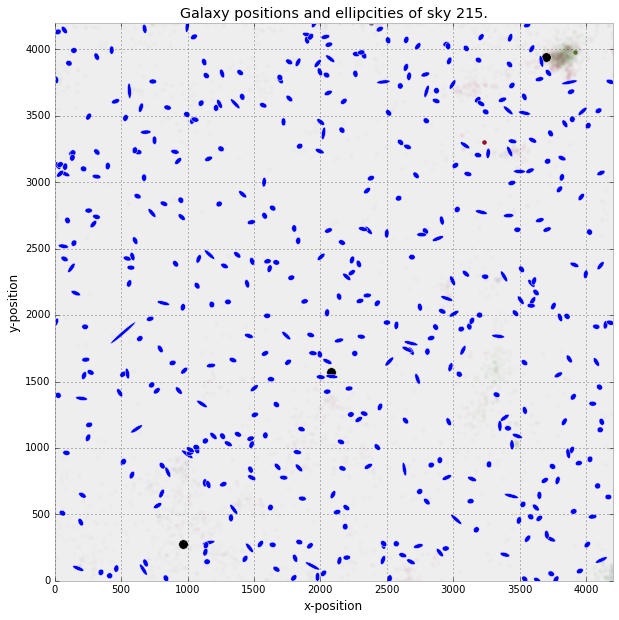

In [23]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0],  traces[:, i, 1], c = colors[i], alpha = 0.02)
    
    
for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky-1][3 + 2*i], halo_data[n_sky-1][4 + 2*i], 
            label = "True halo position", c = "k", s = 90)
    
#plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

This looks pretty good, though it took a long time for the system to (sort of) converge. Our optimization step would look something like this:

In [24]:
_halo_data = halo_data[n_sky-1]
print(traces.shape)

mean_posterior = traces.mean(axis=0).reshape(1,6)
print(mean_posterior)


nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior


print("Using the mean:")
main_score([1], x_true_all, y_true_all, \
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score([1], x_true_all, y_true_all, \
            x_ref_all, y_ref_all, random_guess)

(4500, 3, 2)
[[ 3790.95827012  3794.60133909  3170.00252772  3142.31644835
   2265.01634741  3623.32277728]]
Using the mean:
Your average distance in pixels you are away from the true halo is 175.125422038
Your average angular vector is 1.0
Your score for the training data is 1.17512542204
Using a random location: [[1199 3589]]
Your average distance in pixels you are away from the true halo is 2522.2681726
Your average angular vector is 1.0
Your score for the training data is 3.5222681726


3.5222681725978306

## References
1. Antifragile: Things That Gain from Disorder. New York: Random House. 2012. ISBN 978-1-4000-6782-4.
1.  [Tim Saliman's solution to the Dark World's Contest](http://www.timsalimans.com/observing-dark-worlds)
2. Silver, Nate. The Signal and the Noise: Why So Many Predictions Fail — but Some Don't. 1. Penguin Press HC, The, 2012. Print.

In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()